# Bike Rental Predictions using Linear Regression
This notebook contains the following components: <br>
1) Exploratory Data Analysis of Bike Rentals<br>
2) Baseline OLS Regression model<br>
3) Improved Gradient Descent model using Tensorflow and Keras

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap

# model fit
import statsmodels.api as sm
import tensorflow as tf
from sklearn.metrics import r2_score
import sklearn

# Step 1: Load Data

In [53]:
bikes = pd.read_csv('day.csv')
# summer: can be commented if Full Year
# bikes = bikes[(bikes['mnth']>4) & (bikes['mnth']<10)]
bikes

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


# Step 2: EDA

In [28]:
print("NAs in daily data: \n", bikes.isna().sum())

NAs in daily data: 
 instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [29]:
bikes['weekday'].value_counts()

0    44
2    44
3    44
4    44
5    44
1    43
6    43
Name: weekday, dtype: int64

## Train Test Split

In [54]:
# define outcome #
##################
y = bikes[['cnt', 'casual']].values

# define features #
###################
X = bikes[['season', 'yr', 'mnth','weekday','workingday','weathersit','temp','atemp','hum','windspeed']].values

# split #
#########
np.random.seed(42)
split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int)
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# df for y_test and X_test #
##############################
# easier for EDA later on
df_test = pd.concat(
    [pd.DataFrame(y_test), pd.DataFrame(X_test)],
    axis=1
)

# rename columns
df_train.columns=['cnt', 'casual', 'season', 'yr', 'mnth','weekday','workingday','weathersit','temp','atemp','hum','windspeed']

# rename columns
df_test.columns=['cnt', 'casual', 'season', 'yr', 'mnth','weekday','workingday','weathersit','temp','atemp','hum','windspeed']

In [31]:
df_train.describe()

,cnt,casual,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,5650.911215,1222.658879,2.710280,0.495327,6.967290,3.056075,0.691589,1.289720,0.672447,0.629587,0.638624,0.176050
std,1429.047487,638.612456,0.548311,0.501150,1.431981,1.994508,0.462920,0.474897,0.084780,0.073491,0.124594,0.061364
min,1115.000000,118.000000,2.000000,0.000000,5.000000,0.000000,0.000000,1.000000,0.414167,0.404650,0.305000,0.050379
25%,4579.500000,763.250000,2.000000,0.000000,6.000000,1.000000,0.000000,1.000000,0.619375,0.580188,0.551146,0.132159
50%,5308.500000,1034.000000,3.000000,0.000000,7.000000,3.000000,1.000000,1.000000,0.685417,0.637638,0.636875,0.167606
75%,6898.750000,1464.000000,3.000000,1.000000,8.000000,5.000000,1.000000,2.000000,0.723958,0.669519,0.730209,0.213149
max,8714.000000,3410.000000,4.000000,1.000000,9.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.917083,0.375617


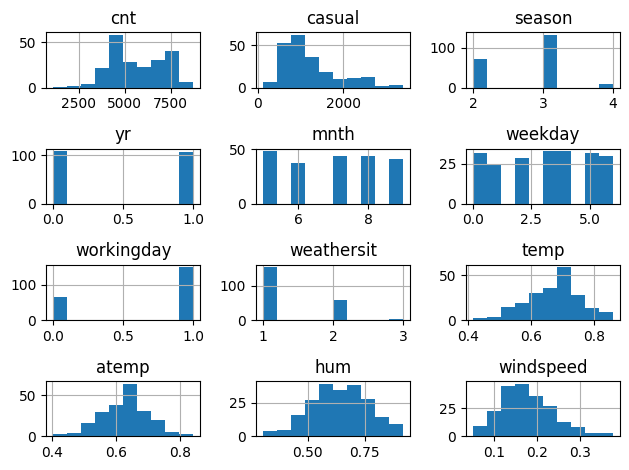

In [32]:
#Distribution of features of interest
df_train.hist()
plt.tight_layout()
plt.show()

## Heatmap on Train Data

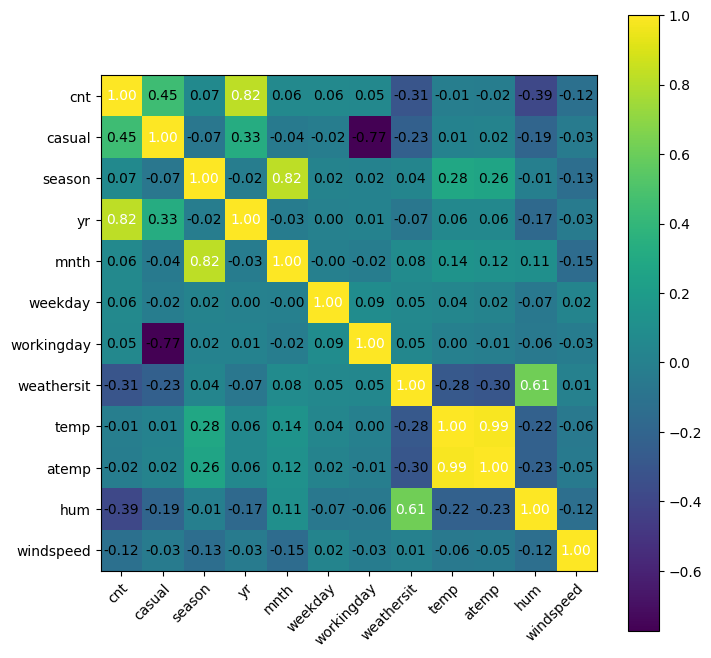

In [33]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(8, 8)
)

# Step 3: Create Baseline - OLS Regression
## The following section will create a base model using rental count as outcome

In [4]:
#rental count as outcome and Linear regression
df_train

,cnt,casual,season,yr,mnth,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,6606,551,4.0,1.0,12.0,2.0,1.0,1.0,0.475833,0.469054,0.733750,0.174129
1,1550,61,1.0,0.0,2.0,4.0,1.0,1.0,0.186957,0.177878,0.437826,0.277752
2,3747,456,4.0,0.0,10.0,5.0,1.0,2.0,0.330833,0.318812,0.585833,0.229479
3,6041,2347,2.0,1.0,4.0,0.0,0.0,2.0,0.425833,0.417287,0.676250,0.172267
4,7538,845,4.0,1.0,9.0,2.0,1.0,1.0,0.550000,0.544179,0.570000,0.236321
...,...,...,...,...,...,...,...,...,...,...,...,...
506,4359,630,2.0,1.0,5.0,1.0,1.0,2.0,0.598333,0.565667,0.811250,0.233204
507,6784,1128,3.0,1.0,8.0,2.0,1.0,1.0,0.726667,0.676779,0.686667,0.169158
508,1623,354,1.0,0.0,2.0,0.0,0.0,1.0,0.285833,0.291671,0.568333,0.141800
509,5698,674,2.0,1.0,3.0,3.0,1.0,1.0,0.484167,0.470950,0.481250,0.291671


In [10]:
base_model = df_train[['cnt', 'hum', 'windspeed']]

base_model_test = df_test[['cnt', 'hum', 'windspeed']]
base_model

,cnt,hum,windspeed
0,6606,0.733750,0.174129
1,1550,0.437826,0.277752
2,3747,0.585833,0.229479
3,6041,0.676250,0.172267
4,7538,0.570000,0.236321
...,...,...,...
506,4359,0.811250,0.233204
507,6784,0.686667,0.169158
508,1623,0.568333,0.141800
509,5698,0.481250,0.291671


## Ordinary Least Squares Regression on Baseline Train model

In [11]:
x_base_train = base_model[['hum', 'windspeed']]
y_base_train = base_model[['cnt']]

#Also do this for the test data for prediction later
x_base_test = base_model_test[[ 'hum', 'windspeed']]
y_base_test = base_model_test[['cnt']]

#only run on train model
base_fit = sm.OLS(y_base_train, x_base_train).fit()
print(base_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.783
Method:                 Least Squares   F-statistic:                              924.4
Date:                Wed, 09 Aug 2023   Prob (F-statistic):                   3.59e-170
Time:                        01:13:29   Log-Likelihood:                         -4671.3
No. Observations:                 511   AIC:                                      9347.
Df Residuals:                     509   BIC:                                      9355.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## The following section will create a baseline temperature model with rental count as outcome.
The only difference between this model and the baseline is that this has the additional temperature variable.

In [12]:
#Temperature model
temp_model = df_train[['cnt', 'hum', 'windspeed', 'temp']]

#Also do the test model
temp_model_test = df_test[['cnt', 'hum', 'windspeed', 'temp']]

temp_model

,cnt,hum,windspeed,temp
0,6606,0.733750,0.174129,0.475833
1,1550,0.437826,0.277752,0.186957
2,3747,0.585833,0.229479,0.330833
3,6041,0.676250,0.172267,0.425833
4,7538,0.570000,0.236321,0.550000
...,...,...,...,...
506,4359,0.811250,0.233204,0.598333
507,6784,0.686667,0.169158,0.726667
508,1623,0.568333,0.141800,0.285833
509,5698,0.481250,0.291671,0.484167


## This section is for Summer model with casual as outcome.

In [35]:
#summer model
summer_model = df_train[['casual', 'hum', 'windspeed', 'temp']]

#Also do the test model
summer_model_test = df_test[['casual', 'hum', 'windspeed', 'temp']]

summer_model

,casual,hum,windspeed,temp
0,745,0.670000,0.134329,0.656667
1,667,0.797083,0.138058,0.564167
2,1914,0.674167,0.104467,0.697500
3,872,0.592083,0.113812,0.782500
4,1027,0.434167,0.185312,0.696667
...,...,...,...,...
209,688,0.597917,0.083333,0.656667
210,736,0.305000,0.292287,0.715000
211,1036,0.596667,0.284813,0.776667
212,1026,0.552083,0.314063,0.505833


## OLS Regression for Summer Model

In [37]:
x_summer_train = summer_model[[ 'hum', 'windspeed', 'temp']]
y_summer_train = summer_model[['casual']]

#Also do this for test for later prediction
x_summer_test = summer_model_test[[ 'hum', 'windspeed', 'temp']]
y_summer_test = summer_model_test[['casual']]

#Only fit on train model
summer_fit = sm.OLS(y_summer_test, x_summer_test).fit()
print(summer_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                 casual   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.752
Method:                 Least Squares   F-statistic:                              94.08
Date:                Wed, 09 Aug 2023   Prob (F-statistic):                    1.66e-27
Time:                        01:25:33   Log-Likelihood:                         -728.17
No. Observations:                  92   AIC:                                      1462.
Df Residuals:                      89   BIC:                                      1470.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Ordinary Least Squares Regression on Temperature Train model

In [13]:
x_temp_train = temp_model[[ 'hum', 'windspeed', 'temp']]
y_temp_train = temp_model[['cnt']]

#Also do this for test for later prediction
x_temp_test = temp_model_test[[ 'hum', 'windspeed', 'temp']]
y_temp_test = temp_model_test[['cnt']]

#Only fit on train model
temp_fit = sm.OLS(y_temp_train, x_temp_train).fit()
print(temp_fit.summary())

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.896
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              1460.
Date:                Wed, 09 Aug 2023   Prob (F-statistic):                   3.20e-249
Time:                        01:13:29   Log-Likelihood:                         -4484.6
No. Observations:                 511   AIC:                                      8975.
Df Residuals:                     508   BIC:                                      8988.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Now, predict and check the MSE for the Baseline and Temperature models

In [14]:
# baseline model test
base_model_test['yhat'] = base_fit.predict(x_base_test)

#temperature model
temp_model_test['yhat'] = temp_fit.predict(x_temp_test)

base_model_test.head()

<ipython-input-14-536c97a2c9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_model_test['yhat'] = base_fit.predict(x_base_test)
<ipython-input-14-536c97a2c9f1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_model_test['yhat'] = temp_fit.predict(x_temp_test)


,cnt,hum,windspeed,yhat
0,5046,0.713750,0.115054,4507.555636
1,3669,0.703333,0.106350,4418.575786
2,6207,0.450833,0.146142,3089.719275
3,6598,0.538333,0.133721,3554.731725
4,5099,0.777917,0.174746,5075.720047


In [15]:
# compute percentage error: actual vs predicted values (for each date/country)
base_model_test['pct_error'] = ((base_model_test.yhat - base_model_test.cnt))*100
temp_model_test['pct_error'] = ((temp_model_test.yhat - temp_model_test.cnt))*100

# compute mean square error (MSE) for each model
print(
    'MSE test baseline model:', np.mean(np.square(base_model_test.yhat - base_model_test.cnt))
)
print(
    'MSE test temperature model:', np.mean(np.square(temp_model_test.yhat - temp_model_test.cnt))
)

MSE test baseline model: 4758363.510700791
MSE test temperature model: 2363498.9373435318


<ipython-input-15-d925e9bfe2b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_model_test['pct_error'] = ((base_model_test.yhat - base_model_test.cnt))*100
<ipython-input-15-d925e9bfe2b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_model_test['pct_error'] = ((temp_model_test.yhat - temp_model_test.cnt))*100


# Step 4: Implement linear regression using Gradient Descent
## This model includes all relevant features and dummies

In [55]:
x_train = df_train.drop(columns=['cnt', 'casual'])
x_train = pd.get_dummies(x_train, columns = ['season', 'weathersit', 'weekday', 'mnth'])
y_train = df_train['cnt']
# y_train = df_train['casual']

In [56]:
x_test = df_test.drop(columns=['cnt', 'casual'])
x_test = pd.get_dummies(x_test, columns = ['season', 'weathersit', 'weekday', 'mnth'])
y_test = df_test[['cnt']]
# y_test = df_test[['casual']]

In [57]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(511, 32)
(511,)
(220, 32)
(220, 1)


In [58]:
def build_compile_tf_model(num_features, learning_rate):
    """Build a TF linear regression model using Keras.

    params:
    -------
    num_features: int, the number of input features
    learning_rate: int, the desired learning rate for SGD

    returns:
    -------
    model: a tf.keras model (graph).
    """
    # This is not strictly necessary, but each time you build a model, TF adds
    # new nodes (rather than overwriting), so the colab session can end up
    # storing lots of copies of the graph when you only care about the most
    # recent. Also, as there is some randomness built into training with SGD,
    # setting a random seed ensures that results are the same on each identical
    # training run.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Build a model using keras.Sequential. While this is intended for neural
    # networks (which may have multiple layers), we want just a single layer for
    # linear regression.
    model = tf.keras.Sequential()

    # create input layer
    model.add(tf.keras.layers.Dense(
        units=1,                     # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
        kernel_initializer=tf.ones_initializer,  # initialize params to 1
        bias_initializer=tf.ones_initializer,    # initialize bias to 1
    ))

    # We need to choose an optimizer. We'll use SGD
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Finally, we compile the model. We specify the MSE loss.
    model.compile(
        optimizer=optimizer,
        loss='mse',
    )



    return model

## Baseline Model with 0.01 Learning Rate

learning_rate: 0.01
---------------------
Epoch 1/50
23/23 [==============================] - 1s 21ms/step - loss: 8521978.0000 - val_loss: 3595373.2500
Epoch 2/50
23/23 [==============================] - 0s 14ms/step - loss: 2267538.5000 - val_loss: 2226882.2500
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 1800114.8750 - val_loss: 1871976.7500
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 1558175.1250 - val_loss: 1630366.5000
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 1378441.5000 - val_loss: 1460694.5000
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 1240317.5000 - val_loss: 1324407.7500
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 1139116.3750 - val_loss: 1228695.6250
Epoch 8/50
23/23 [==============================] - 0s 6ms/step - loss: 1058419.1250 - val_loss: 1153319.8750
Epoch 9/50
23/23 [==============================] - 0s 8ms/step - loss: 9978

Text(0, 0.5, 'Loss')

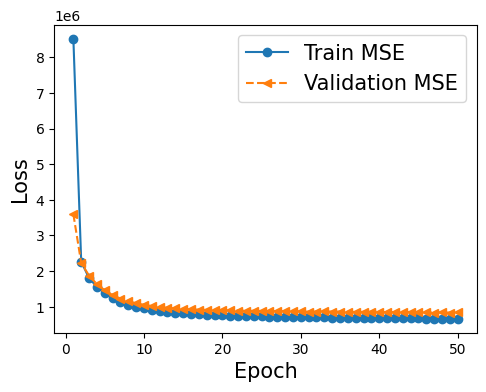

In [67]:
# define learning rates
learning_rate = 0.01

# create dictionary to keep track of loss
growth_rate_mse_dict = {}


print('learning_rate:', learning_rate)
print('---------------------')

# Build and compile the model #
############################################
model = build_compile_tf_model(
    num_features=x_train.shape[1],
    learning_rate=learning_rate
)

baseline_fit_tf = model.fit(
x = x_train,
y = y_train,
validation_split=0.1,
epochs=50,
batch_size=20,
verbose=1) # do not silence the output

hist = baseline_fit_tf.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train MSE')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation MSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



In [65]:
preds = model.predict(x_test)
print(r2_score(y_test, preds))

7/7 [==============================] - 0s 3ms/step
0.6691788664925595


## Change Learning Rate: Baseline Model with 0.001 Learning Rate

learning_rate: 0.001
---------------------
Epoch 1/50
23/23 [==============================] - 1s 11ms/step - loss: 20105802.0000 - val_loss: 20989290.0000
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 15042105.0000 - val_loss: 16091882.0000
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 11426807.0000 - val_loss: 12538471.0000
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 8841942.0000 - val_loss: 9944572.0000
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 6988746.0000 - val_loss: 8045415.5000
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 5655136.5000 - val_loss: 6640480.5000
Epoch 7/50
23/23 [==============================] - 0s 4ms/step - loss: 4692160.5000 - val_loss: 5601983.0000
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 3994368.7500 - val_loss: 4822870.0000
Epoch 9/50
23/23 [==============================] - 0s 3ms/step - loss

Text(0, 0.5, 'Loss')

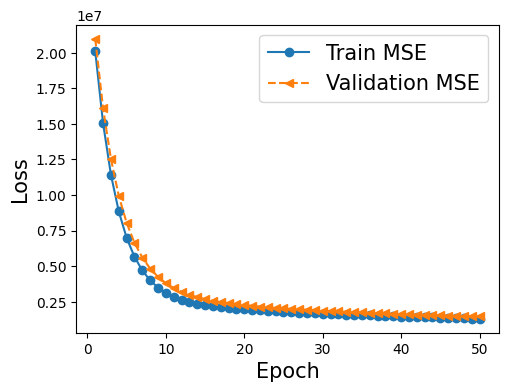

In [68]:
# define learning rates
learning_rate = 0.001

# create dictionary to keep track of loss
growth_rate_mse_dict = {}


print('learning_rate:', learning_rate)
print('---------------------')

# Build and compile the baseline model #
############################################
model = build_compile_tf_model(
    num_features=x_train.shape[1],
    learning_rate=learning_rate
)

baseline_fit_tf = model.fit(
x = x_train,
y = y_train,
validation_split=0.1,
epochs=50,
batch_size=20, #use all the data
verbose=1) # do not silence the output

hist = baseline_fit_tf.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train MSE')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation MSE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



In [51]:
preds = model.predict(x_test)
print(r2_score(y_test, preds))

3/3 [==============================] - 0s 4ms/step
0.6044205086238151


## Step 5: Evaluate Baseline Model with Test Data

In [66]:
# Evaluate on test data
test_loss = model.evaluate(x_test, y_test, verbose = 1)
print('Test RMSE: ', np.sqrt(test_loss))

7/7 [==============================] - 0s 3ms/step - loss: 1141643.2500
Test RMSE:  1068.4770704137736
